In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Flatten, Bidirectional,Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from IPython.display import Image

Using TensorFlow backend.


## Import data , same dataset used on missing data repos

In [2]:
df = pd.read_csv("history_export_2018-12-04T18_30_11.csv",skiprows=12, header=None,
                 delimiter=';', names=['year',
                                       'month',
                                       'day',
                                       'hour',
                                       'minute',
                                       'temp',
                                       'shortwave_rad'])

In [3]:
df['Datetime']=pd.to_datetime(df[['year','month','day','hour']])
df.head()

,year,month,day,hour,minute,temp,shortwave_rad,Datetime
0,2018,11,27,0,0,16.79,0.0,2018-11-27 00:00:00
1,2018,11,27,1,0,16.71,0.0,2018-11-27 01:00:00
2,2018,11,27,2,0,16.58,0.0,2018-11-27 02:00:00
3,2018,11,27,3,0,16.18,0.0,2018-11-27 03:00:00
4,2018,11,27,4,0,15.94,0.0,2018-11-27 04:00:00


In [4]:
df.drop(columns=['year', 'month', 'day', 'hour', 'minute','shortwave_rad'], axis=1, inplace=True)

In [5]:
df.set_index('Datetime', inplace=True)

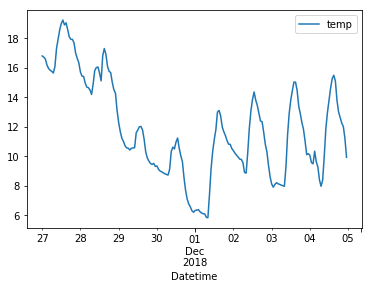

In [6]:
df.plot()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2018-11-27 00:00:00 to 2018-12-04 23:00:00
Data columns (total 1 columns):
temp    192 non-null float64
dtypes: float64(1)
memory usage: 3.0 KB


In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df.shape[0]

192

In [10]:
df.isnull().sum()

temp    0
dtype: int64

# Logic of "Sliding Windows"
### Image link: https://i.stack.imgur.com/rfSAF.png

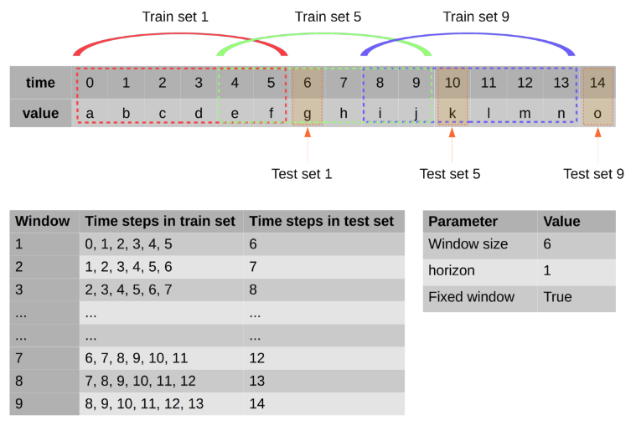

In [11]:
Image("pic_rnn/rfSAF.png")


# Define data for prediction and for training
## For training use all the data except the last 24 hours.¶
## For eval use the last 24 hours.

In [12]:
train=df.iloc[:len(df)-24]
test=df.iloc[len(train):]

In [13]:
train=np.array(train)
train=train.reshape(train.shape[0],1)

In [14]:
x_test=df[len(df)-len(test):]
x_test=x_test.values.reshape(-1,1)

# Data normalization using "MinMaxScaler"

In [15]:
scaler=MinMaxScaler(feature_range=(0,1))
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
train_scaled=scaler.transform(train)

In [17]:
x_test_scaled=scaler.transform(x_test)

# Sliding window with step 5

In [18]:
timestep = 5
x_test = []
y_test = []


for i in range(timestep,x_test_scaled.shape[0]):
    x_test.append(x_test_scaled[i-timestep:i,0])
    y_test.append(x_test_scaled[i,0])

x_test,y_test=np.array(x_test),np.array(y_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print("x_test shape= ",x_test.shape)
print("y_test shape= ",y_test.shape)

x_test shape=  (19, 5, 1)
y_test shape=  (19,)


In [19]:
y_test=np.array(y_test)
y_test=y_test.reshape(len(y_test),1)

In [20]:
y_test=scaler.inverse_transform(y_test)

In [21]:
timestep = 5
x_train = []
y_train = []


for i in range(timestep,train_scaled.shape[0]):
    x_train.append(train_scaled[i-timestep:i,0])
    y_train.append(train_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (163, 5, 1)
y_train shape=  (163,)


## First sequence have an length of the first 5 values , the 6th value goes to y_train etc

In [22]:
x_train

array([[[0.81852128],
        [0.81254668],
        [0.80283794],
        [0.7729649 ],
        [0.75504108]],

       [[0.81254668],
        [0.80283794],
        [0.7729649 ],
        [0.75504108],
        [0.74607916]],

       [[0.80283794],
        [0.7729649 ],
        [0.75504108],
        [0.74607916],
        [0.74085138]],

       [[0.7729649 ],
        [0.75504108],
        [0.74607916],
        [0.74085138],
        [0.73188947]],

       [[0.75504108],
        [0.74607916],
        [0.74085138],
        [0.73188947],
        [0.76400299]],

       [[0.74607916],
        [0.74085138],
        [0.73188947],
        [0.76400299],
        [0.85586258]],

       [[0.74085138],
        [0.73188947],
        [0.76400299],
        [0.85586258],
        [0.90440627]],

       [[0.73188947],
        [0.76400299],
        [0.85586258],
        [0.90440627],
        [0.95070948]],

       [[0.76400299],
        [0.85586258],
        [0.90440627],
        [0.95070948],
        [0.98207

In [23]:
y_train 

array([0.74607916, 0.74085138, 0.73188947, 0.76400299, 0.85586258,
       0.90440627, 0.95070948, 0.98207618, 1.        , 0.97535474,
       0.98581031, 0.95220314, 0.91486184, 0.9021658 , 0.9021658 ,
       0.88349515, 0.83271098, 0.80657207, 0.78342046, 0.73711725,
       0.71620612, 0.71471247, 0.68185213, 0.660941  , 0.6579537 ,
       0.64600448, 0.6235997 , 0.67737117, 0.74533234, 0.75952203,
       0.76250934, 0.73188947, 0.69230769, 0.81926811, 0.85586258,
       0.82673637, 0.76549664, 0.74085138, 0.73412995, 0.68409261,
       0.64749813, 0.62957431, 0.54294249, 0.48170276, 0.43614638,
       0.40253921, 0.38610904, 0.36445108, 0.35324869, 0.35175504,
       0.34279313, 0.35100822, 0.35324869, 0.35399552, 0.42942494,
       0.44361464, 0.46004481, 0.46153846, 0.44361464, 0.39581777,
       0.33233757, 0.3017177 , 0.28603435, 0.27408514, 0.26960418,
       0.27483196, 0.25989544, 0.26213592, 0.24495892, 0.23599701,
       0.23226288, 0.2270351 , 0.22255414, 0.21882001, 0.21583

## All the transformed values

In [24]:
df_scaled = scaler.transform(df)

In [25]:
df_scaled

array([[0.81852128],
       [0.81254668],
       [0.80283794],
       [0.7729649 ],
       [0.75504108],
       [0.74607916],
       [0.74085138],
       [0.73188947],
       [0.76400299],
       [0.85586258],
       [0.90440627],
       [0.95070948],
       [0.98207618],
       [1.        ],
       [0.97535474],
       [0.98581031],
       [0.95220314],
       [0.91486184],
       [0.9021658 ],
       [0.9021658 ],
       [0.88349515],
       [0.83271098],
       [0.80657207],
       [0.78342046],
       [0.73711725],
       [0.71620612],
       [0.71471247],
       [0.68185213],
       [0.660941  ],
       [0.6579537 ],
       [0.64600448],
       [0.6235997 ],
       [0.67737117],
       [0.74533234],
       [0.75952203],
       [0.76250934],
       [0.73188947],
       [0.69230769],
       [0.81926811],
       [0.85586258],
       [0.82673637],
       [0.76549664],
       [0.74085138],
       [0.73412995],
       [0.68409261],
       [0.64749813],
       [0.62957431],
       [0.542

## The rnn models takes as input (Length of sequence, features)
## Below are used 3 different models for this task

# First model using SimpleRNN cells

In [26]:
model_srnn=Sequential()

model_srnn.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
model_srnn.add(Dropout(0.25))
model_srnn.add(SimpleRNN(256,activation="relu",return_sequences=True))
model_srnn.add(Dropout(0.25))

model_srnn.add(Flatten())
model_srnn.add(Dense(1, activation='linear'))

model_srnn.compile(loss="mean_squared_error",optimizer="adam")


In [27]:
model_srnn.fit(x_train,y_train,epochs=10,batch_size=36)

Epoch 1/10
163/163 [==============================] - 0s 3ms/step - loss: 0.1407
Epoch 2/10
163/163 [==============================] - 0s 330us/step - loss: 0.0418
Epoch 3/10
163/163 [==============================] - 0s 324us/step - loss: 0.0319
Epoch 4/10
163/163 [==============================] - 0s 324us/step - loss: 0.0189
Epoch 5/10
163/163 [==============================] - 0s 312us/step - loss: 0.0203
Epoch 6/10
163/163 [==============================] - 0s 330us/step - loss: 0.0139
Epoch 7/10
163/163 [==============================] - 0s 337us/step - loss: 0.0160
Epoch 8/10
163/163 [==============================] - 0s 337us/step - loss: 0.0135
Epoch 9/10
163/163 [==============================] - 0s 346us/step - loss: 0.0125
Epoch 10/10
163/163 [==============================] - 0s 355us/step - loss: 0.0112


In [28]:
predict_srnn=model_srnn.predict(x_test)
predict_srnn=scaler.inverse_transform(predict_srnn)

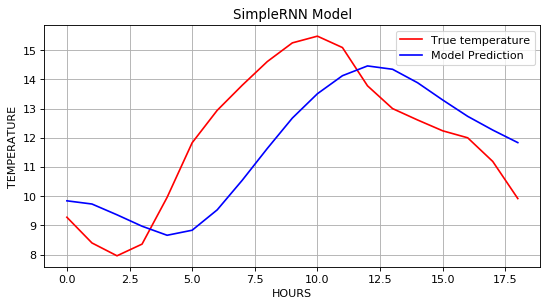

In [29]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test,color="r",label="True temperature")
plt.plot(predict_srnn,color="b",label="Model Prediction")
plt.legend()
plt.xlabel("HOURS")
plt.ylabel("TEMPERATURE")
plt.title("SimpleRNN Model")
plt.grid(True)

In [30]:
mse_srnn = mean_absolute_error(y_true=y_test, y_pred=predict_srnn)
mse_srnn

1.6543817881533978

# Second model using LSTM cells

In [31]:
model_lstm=Sequential()

model_lstm.add(LSTM(128,input_shape=(x_train.shape[1],1),activation="relu",return_sequences=True))
model_lstm.add(Dropout(0.25))
model_lstm.add(LSTM(256,activation="relu",return_sequences=False))
model_lstm.add(Dropout(0.25))
model_lstm.add(Dense(1, activation='linear'))

model_lstm.compile(loss="mean_squared_error",optimizer="adam")


In [32]:
model_lstm.fit(x_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
163/163 [==============================] - 2s 10ms/step - loss: 0.2291
Epoch 2/10
163/163 [==============================] - 0s 1ms/step - loss: 0.1050
Epoch 3/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 4/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0371
Epoch 5/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 6/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 7/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 8/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 9/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 10/10
163/163 [==============================] - 0s 1ms/step - loss: 0.0160


In [33]:
predict_lstm=model_lstm.predict(x_test)
predict_lstm=scaler.inverse_transform(predict_lstm)

In [34]:
mse_lstm = mean_absolute_error(y_true=y_test, y_pred=predict_lstm)
mse_lstm

2.042144209209242

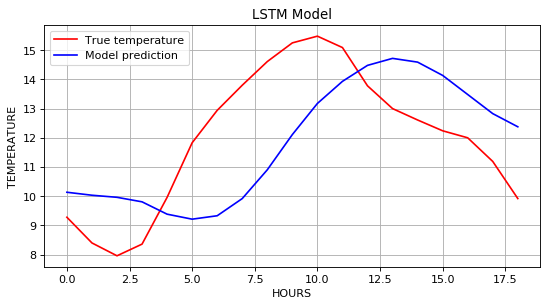

In [35]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test,color="r",label="True temperature")
plt.plot(predict_lstm,color="b",label="Model prediction")
plt.legend()
plt.xlabel("HOURS")
plt.ylabel("TEMPERATURE")
plt.title("LSTM Model")
plt.grid(True)

# Third model using Biderectional with SimpleRNN

In [36]:
model_bi = Sequential()

model_bi.add(Bidirectional(SimpleRNN(128, return_sequences=True), input_shape=(x_train.shape[1],1)))
model_bi.add(Dropout(0.25))
model_bi.add(Activation('relu'))
model_bi.add(Bidirectional(SimpleRNN(256, return_sequences=False)))
model_bi.add(Dropout(0.25))
model_bi.add(Activation('relu'))
model_bi.add(Dense(1, activation='linear'))

model_bi.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
model_bi.fit(x_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
163/163 [==============================] - 1s 6ms/step - loss: 0.3054
Epoch 2/10
163/163 [==============================] - 0s 626us/step - loss: 0.0580
Epoch 3/10
163/163 [==============================] - 0s 658us/step - loss: 0.0410
Epoch 4/10
163/163 [==============================] - 0s 670us/step - loss: 0.0269
Epoch 5/10
163/163 [==============================] - 0s 688us/step - loss: 0.0119
Epoch 6/10
163/163 [==============================] - 0s 618us/step - loss: 0.0081
Epoch 7/10
163/163 [==============================] - 0s 624us/step - loss: 0.0064
Epoch 8/10
163/163 [==============================] - 0s 636us/step - loss: 0.0081
Epoch 9/10
163/163 [==============================] - 0s 618us/step - loss: 0.0071
Epoch 10/10
163/163 [==============================] - 0s 642us/step - loss: 0.0079


In [38]:
predict_bi=model_bi.predict(x_test)
predict_bi=scaler.inverse_transform(predict_bi)

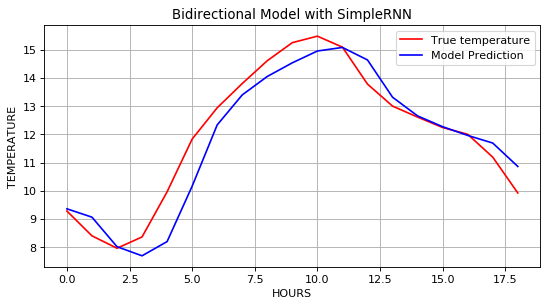

In [39]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test,color="r",label="True temperature")
plt.plot(predict_bi,color="b",label="Model Prediction")
plt.legend()
plt.xlabel("HOURS")
plt.ylabel("TEMPERATURE")
plt.title("Bidirectional Model with SimpleRNN")
plt.grid(True)

In [40]:
mse_bi = mean_absolute_error(y_true=y_test, y_pred=predict_bi)
mse_bi

0.5493554787886774